# Kategorinen data ja puuttuvien arvojen käsittely

In [39]:
import pandas as pd 
import numpy as np 

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import os 

In [40]:
# luetaan data ja tallennetaan se csv-tiedostoon
if os.path.exists('abnd_listings.csv'):
    df = pd.read_csv('abnd_listings.csv')
else:
    df = pd.read_csv('https://raw.githubusercontent.com/InfoTUNI/joda2022/master/koodiesimerkit/data.csv')
    df.to_csv('abnd_listings.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16313 entries, 0 to 16312
Data columns (total 98 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0.1                      16313 non-null  int64  
 1   Unnamed: 0                        16313 non-null  int64  
 2   id                                16313 non-null  int64  
 3   listing_url                       16313 non-null  object 
 4   scrape_id                         16313 non-null  int64  
 5   last_scraped                      16313 non-null  object 
 6   name                              16302 non-null  object 
 7   summary                           15860 non-null  object 
 8   space                             11798 non-null  object 
 9   description                       16305 non-null  object 
 10  experiences_offered               16313 non-null  object 
 11  neighborhood_overview             10343 non-null  object 
 12  note

In [41]:
df_no_missing = df[['host_response_time', 'host_response_rate', 'review_scores_rating']].copy()

print(df_no_missing.head())
print(df_no_missing.host_response_time.unique())

  host_response_time host_response_rate  review_scores_rating
0       within a day                60%                  89.0
1     within an hour               100%                  91.0
2     within an hour               100%                  79.0
3     within an hour               100%                  90.0
4     within an hour               100%                  80.0
['within a day' 'within an hour' 'within a few hours' nan
 'a few days or more']


In [42]:
df_no_missing.host_response_rate = df_no_missing.host_response_rate.str.strip('%')
df_no_missing.host_response_rate = pd.to_numeric(df_no_missing.host_response_rate)

print(df_no_missing.info, '\n')
print(df_no_missing.dtypes, '\n')
print(df_no_missing.head(), '\n')

null_counts = df_no_missing.isnull().sum()
print(f"Null values count: \n {null_counts}")

<bound method DataFrame.info of        host_response_time  host_response_rate  review_scores_rating
0            within a day                60.0                  89.0
1          within an hour               100.0                  91.0
2          within an hour               100.0                  79.0
3          within an hour               100.0                  90.0
4          within an hour               100.0                  80.0
...                   ...                 ...                   ...
16308  within a few hours               100.0                   NaN
16309  within a few hours                70.0                   NaN
16310      within an hour               100.0                   NaN
16311      within an hour                96.0                   NaN
16312      within an hour                91.0                   NaN

[16313 rows x 3 columns]> 

host_response_time       object
host_response_rate      float64
review_scores_rating    float64
dtype: object 

  host_resp

In [43]:
# Pudotetaan rivit, joissa on puuttuvia arvoja
df_no_missing = df_no_missing.dropna()
df_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11855 entries, 0 to 16218
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_time    11855 non-null  object 
 1   host_response_rate    11855 non-null  float64
 2   review_scores_rating  11855 non-null  float64
dtypes: float64(2), object(1)
memory usage: 370.5+ KB


In [44]:
# Kategorisoidaan host_response_time -sarake
le = preprocessing.LabelEncoder()
arr = le.fit_transform(df_no_missing.host_response_time)
df_no_missing.host_response_time = arr 

In [45]:
print(arr)
df_no_missing.head()

[1 3 3 ... 3 3 3]


,host_response_time,host_response_rate,review_scores_rating
0,1,60.0,89.0
1,3,100.0,91.0
2,3,100.0,79.0
3,3,100.0,90.0
4,3,100.0,80.0


In [46]:
# Käytetään lineaarista mallia, joka ennustaa review_scores_rating -sarakeen arvoja.
lr = linear_model.LinearRegression()
y = df_no_missing.review_scores_rating
X = df_no_missing.drop(columns='review_scores_rating')


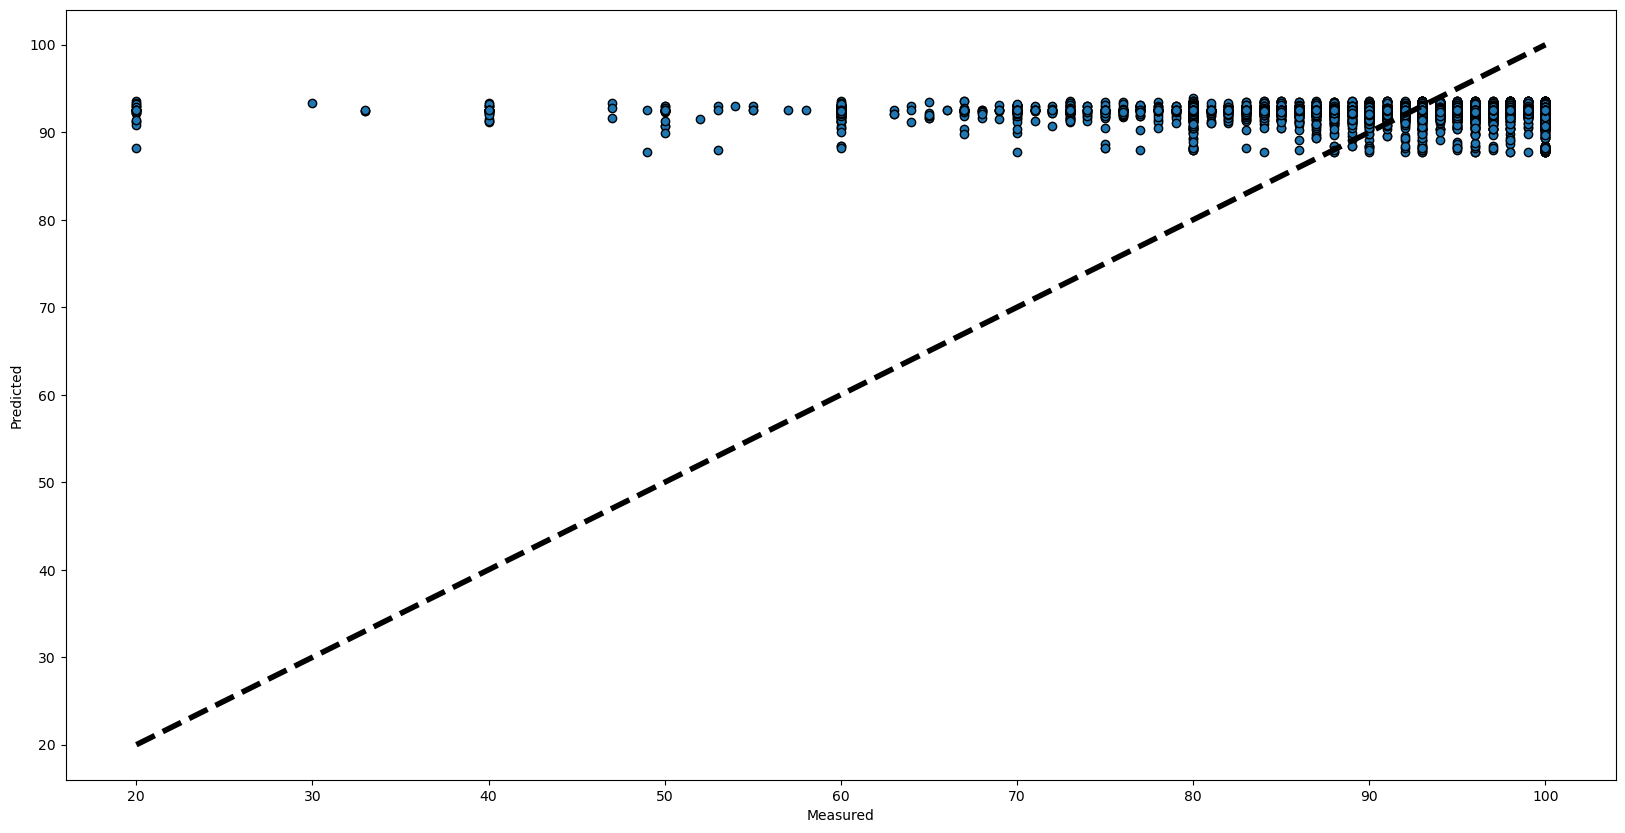

In [47]:
predictions = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots(figsize = (20,10))

ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [48]:
print(df_no_missing.corr())


                      host_response_time  host_response_rate  \
host_response_time              1.000000            0.586101   
host_response_rate              0.586101            1.000000   
review_scores_rating            0.018660            0.066256   

                      review_scores_rating  
host_response_time                0.018660  
host_response_rate                0.066256  
review_scores_rating              1.000000  


In [49]:
mse = mean_squared_error(predictions, y)
mae = mean_absolute_error(predictions, y)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

Mean squared error: 72.83
Mean absolute error: 5.72


# Toinen lähestymistapa - Täytetään tyhjät arvot mediaanilla 

In [50]:
df_imp = df[['review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication',
         'review_scores_location','review_scores_value',
         'review_scores_rating']].copy()

print(df_imp.isnull().sum())


review_scores_accuracy         3208
review_scores_cleanliness      3202
review_scores_checkin          3224
review_scores_communication    3209
review_scores_location         3230
review_scores_value            3231
review_scores_rating           3195
dtype: int64


In [51]:
# Tarkastellaan otettujen muuttujien mediaaneja
df_imp.median()

review_scores_accuracy         10.0
review_scores_cleanliness      10.0
review_scores_checkin          10.0
review_scores_communication    10.0
review_scores_location         10.0
review_scores_value             9.0
review_scores_rating           95.0
dtype: float64

In [52]:
# Lisätään tyhjiin arvioihin kyseiisten sarakkeiden mediaaniarvot
df_imp = df_imp.fillna(df_imp.median())
print(df_imp.isnull().sum())

review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
review_scores_rating           0
dtype: int64


# Ennustetaan lineaarisella mallilla arvostelut jossa tyhjät arvot korvattu kyseisen sarakkeen mediaanilla

In [53]:
# Käytetään lineaarista mallia, joka ennustaa review_scores_rating -sarakeen arvoja.

lr = linear_model.LinearRegression()

y = df_imp.review_scores_rating
X = df_imp.drop(columns='review_scores_rating')

predictions = cross_val_predict(lr, X, y, cv=10)

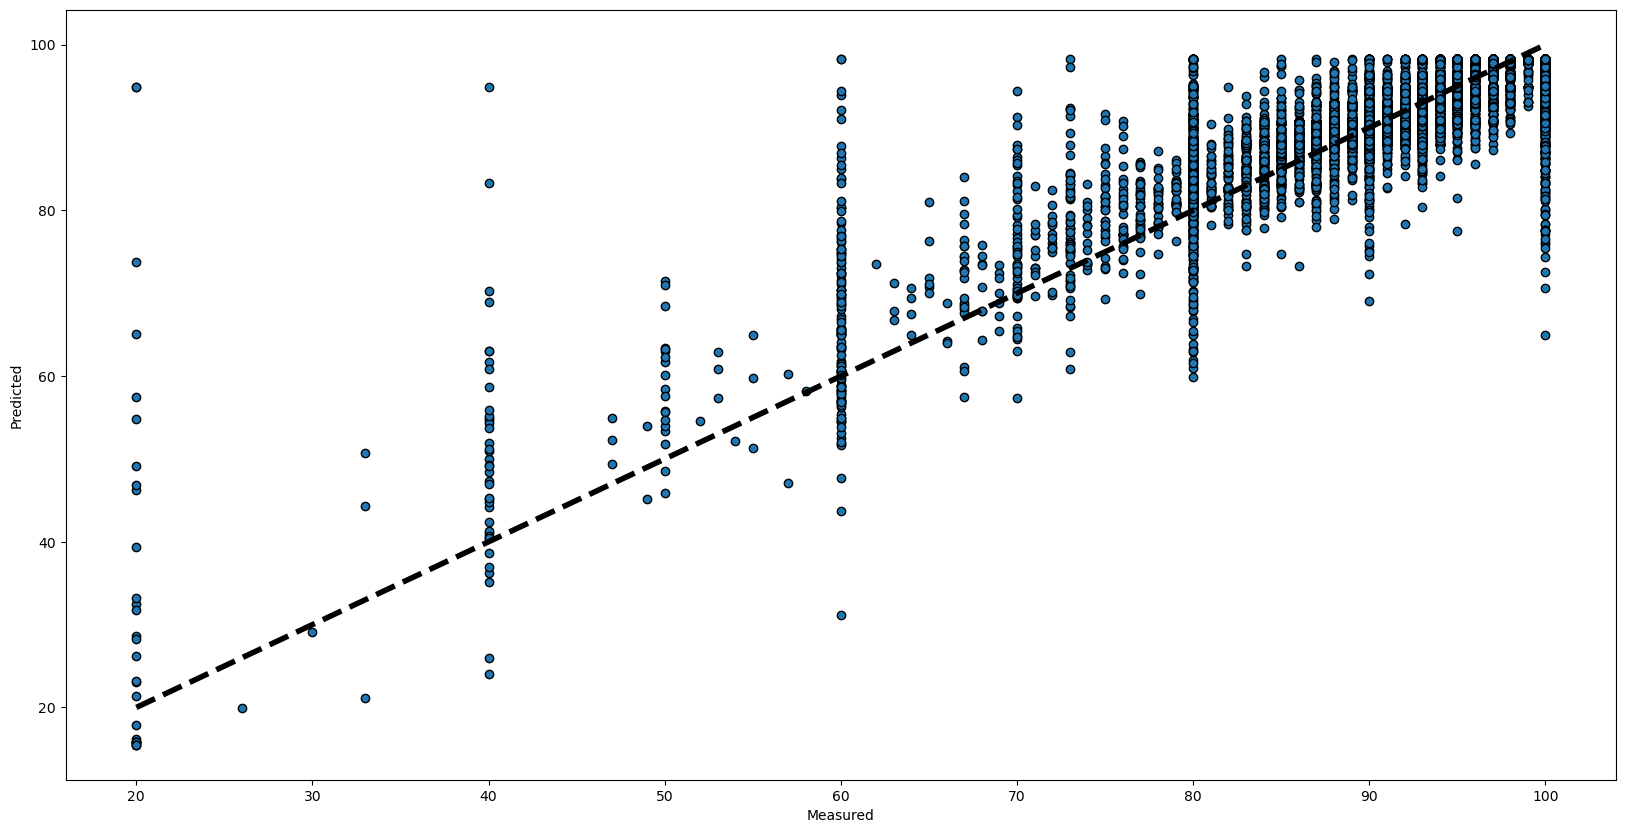

In [54]:
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [55]:
print(df_imp.corr()['review_scores_rating'])

review_scores_accuracy         0.759918
review_scores_cleanliness      0.702815
review_scores_checkin          0.632046
review_scores_communication    0.663075
review_scores_location         0.433515
review_scores_value            0.766700
review_scores_rating           1.000000
Name: review_scores_rating, dtype: float64


In [56]:
# Tarkastellaan lineaarisen mallin virheitä 

mse = mean_squared_error(predictions, y)
mae = mean_absolute_error(predictions, y)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

Mean squared error: 15.76
Mean absolute error: 2.27


# Käytetään satunnaista päätöspuumetsää ja optimoidaan hyperparametrit satunnaisella haulla 

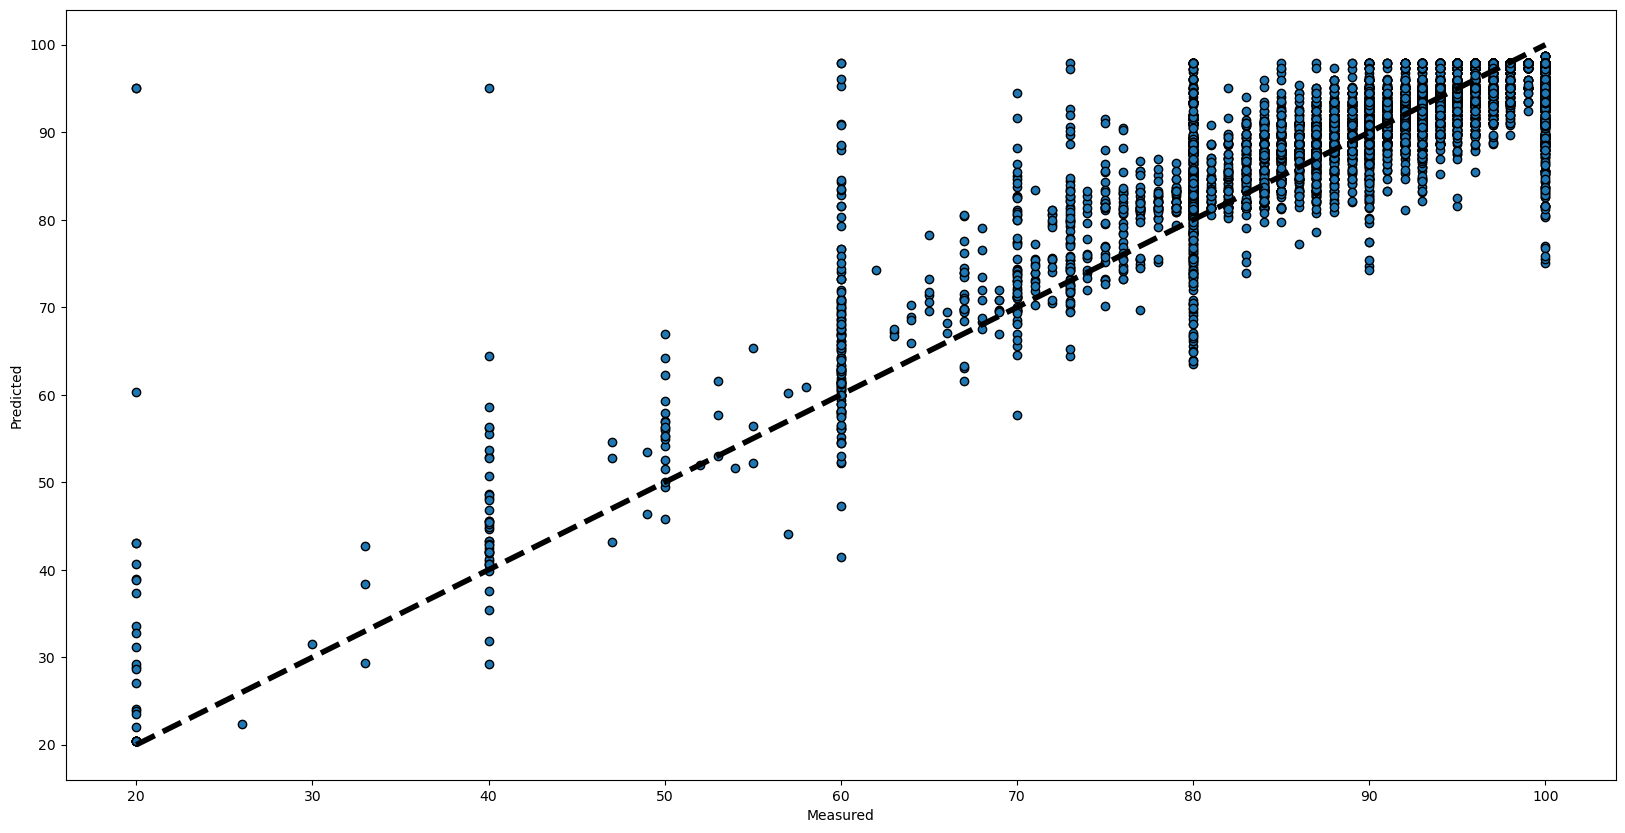

Mean squared error: 13.61
Mean absolute error: 2.16


In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

# Määritellään hyperparametrien etsintäavaruus
param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Haetaan parhaat hyperparametrit
random_search = RandomizedSearchCV(
estimator = rf,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 1000,
verbose = 0
)

random_search.fit(X, y)
best_model = random_search.best_estimator_

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y)
mae = mean_absolute_error(predictions, y)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")

# Testataan XGBoost mallia ja etsitään sillekin hyperparametrit 

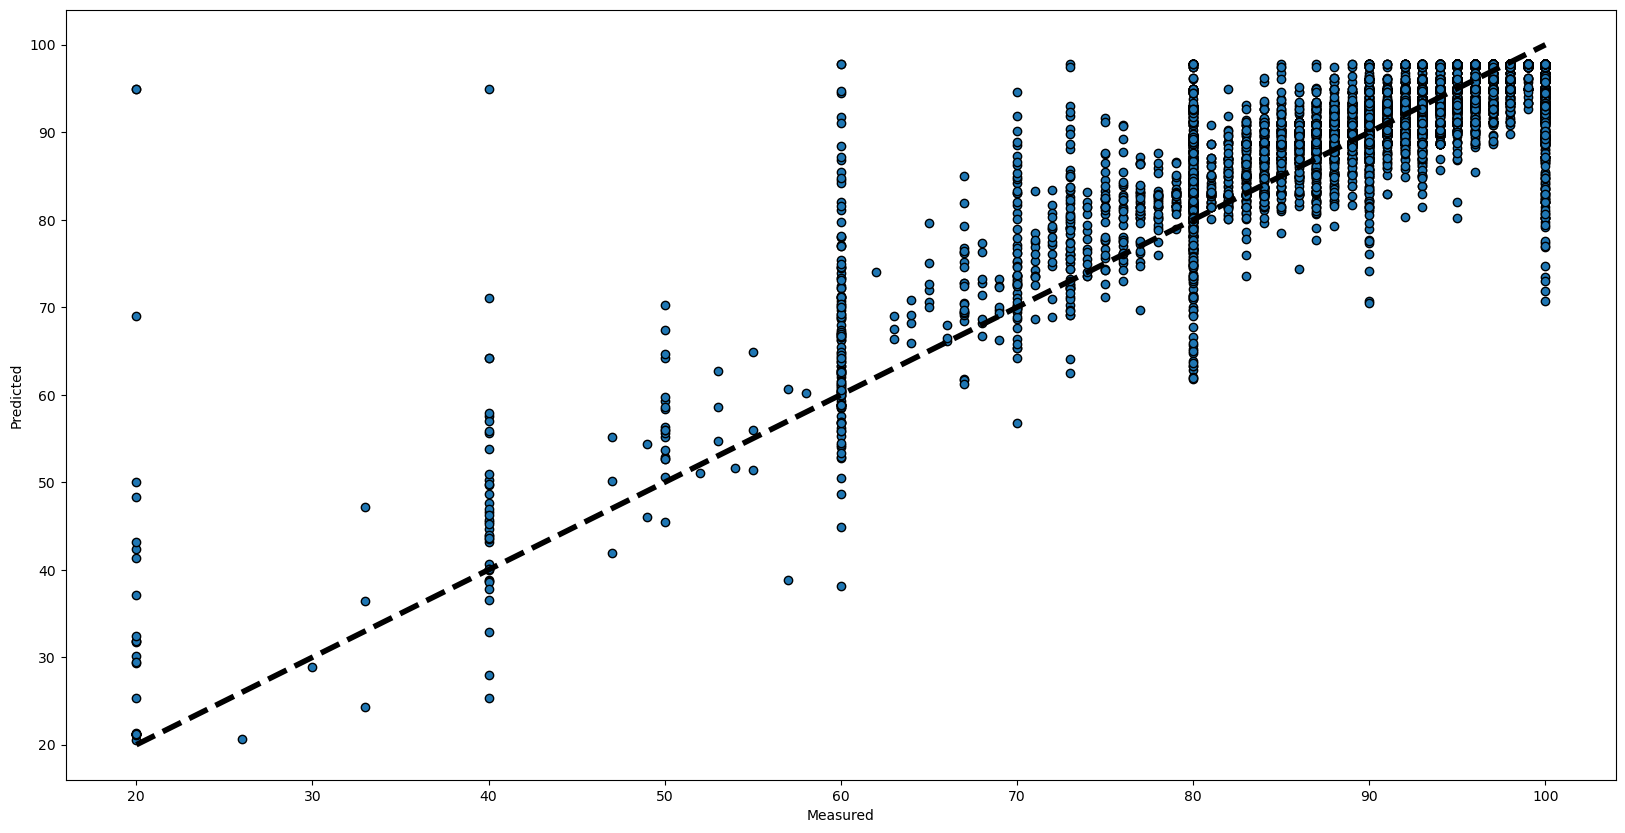

Mean squared error: 14.84
Mean absolute error: 2.23


In [58]:
import xgboost

# Käyetään xgboost -mallia MSE objektiivilla
xgb = xgboost.XGBRegressor(objective ='reg:squarederror')

param_space = {
    'n_estimators': np.arange(1, 500, 10),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2] 
}

random_search = RandomizedSearchCV(
estimator = xgb,
param_distributions = param_space,
cv = 5,
n_jobs= -2,
n_iter = 10000,
verbose = 0
)


random_search.fit(X, y)
best_model = random_search.best_estimator_

# Käytetään parhaita hyperparametrejä
predictions = best_model.predict(X)

# Tarkastellaan mallin toimivuutta
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(y, predictions, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

mse = mean_squared_error(predictions, y)
mae = mean_absolute_error(predictions, y)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}")
